# Imports

In [24]:
from __future__ import division
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
import matplotlib
import numpy as np
import random
from numpy import linalg as LA
from PIL import Image
import sys
import itertools
import scipy.linalg as s_linalg
import math

# Data Preprocessing

In [2]:
# '''This is the command to read in the GIF. You need Videocapture which makes a cv2 Video Object.
# Add your GIF file name in the parameter of this function.
# '''
# #gif_kiss = cv2.VideoCapture('test.gif')


# def convert_gif_to_frames(gif):

#     # Initialize the frame number and create empty frame list
#     frame_num = 0
#     frame_list = []

#     # Loop until there are frames left
#     while True:
#         try:
#             # Try to read a frame. Okay is a BOOL if there are frames or not
#             okay, frame = gif.read()
#             # Append to empty frame list
#             frame_list.append(frame)
#             # Break if there are no other frames to read
#             if not okay:
#                 break
#             # Increment value of the frame number by 1
#             frame_num += 1
#         except KeyboardInterrupt:  # press ^C to quit
#             break

#     return frame_list


# def output_frames_as_pics(frame_list):

#     # Reduce the list of frames by half to make the list more managable
#     frame_list_reduce = frame_list[0::2]
#     # Get the path of the current working directory
#     path = os.getcwd()
#     # Set then name of your folder
#     '''Replace this name with what you want your folder name to be'''
#     folder_name = 'Picturebook_Pics_Kiss'
#     # If the folder does not exist, then make it
#     if not os.path.exists(path + '/' + folder_name):
#         os.makedirs(path + '/' + folder_name)

#     for frames_idx in range(len(frame_list_reduce)):
#         cv2.imwrite(os.path.join(path + '/' + folder_name, str(frames_idx+1) + '.png'), frame_list_reduce[frames_idx])

# pass

In [3]:
# cap = cv2.VideoCapture('test1.gif')
# a = convert_gif_to_frames(cap)
# cv2.imshow('Original image',a[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [4]:
# a = convert_gif_to_frames(cap)

In [5]:
# img = Image.open('test.gif') # image extension *.png,*.jpg
# new_width  = 50
# new_height = 50
# img = img.resize((new_width, new_height), Image.ANTIALIAS)
# img.save('resize_images/test1.gif') # format may what u want ,*.png,*jpg,*.gif

In [6]:
# cap = cv2.imread('Aberdeen/lisa1.jpg')
# gray = cv2.cvtColor(cap, cv2.COLOR_BGR2GRAY)
# cv2.imshow('Original image',cap)
# cv2.imshow('Gray image', gray)
 
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [7]:
# len(a[0][0])

In [8]:
# len(cap[0][0])

In [9]:
# len(gray[0])

In [10]:
# plt.imshow(gray,cmap='gray')
# plt.show()

In [11]:
# images = []

In [12]:
# images

In [13]:
# new_width  = 50
# new_height = 50
# for root, dirs, files in os.walk('./face_dataset'):
#     k = 0
#     for name in files:
#         #print(name)
#         cap = cv2.VideoCapture('./face_dataset/'+name)
#         img = Image.open('./face_dataset/'+name) # image extension *.png,*.jpg
#         img = img.resize((new_width, new_height), Image.ANTIALIAS)
#         img.save('resize_images/'+name) # format may what u want ,*.png,*jpg,*.gif

In [14]:
# new_width  = 50
# new_height = 50
# for root, dirs, files in os.walk('./Aberdeen'):
#     k = 0
#     for name in files:
#         #print(name)
#         #cap = cv2.VideoCapture('./face_dataset/'+name))
#         img = Image.open('./Aberdeen/'+name).convert('LA') # image extension *.png,*.jpg
#         img = img.resize((new_width, new_height), Image.ANTIALIAS)
#         img.save('aberdeen_resize_images/'+name) # format may what u want ,*.png,*jpg,*.gif

In [51]:
# for root, dirs, files in os.walk('./Aberdeen'):
#     k = 0
#     for name in files:
#         #print(name)
#         #cap = cv2.VideoCapture('./face_dataset/'+name))
#         img = Image.open('./Aberdeen/'+name) # image extension *.png,*.jpg
#         img = img.resize((new_width, new_height), Image.ANTIALIAS)
#         img.save('aberdeen_resize_images/'+name) # format may what u want ,*.png,*jpg,*.gif

In [71]:
def read_aberdeen_dataset():
    img_name = []
    dataset = {}
    win_height = sys.maxsize
    win_width = sys.maxsize
    key = ''
    for root, dirs, files in os.walk('./aberdeen_resize_images'):
        if not (root == './aberdeen_resize_images'):
            key = root.split('\\')[1]
            dataset[key] = []
        for name in files:
            img_name.append(name)
    #         d[key].append(name)
            cap = cv2.imread('./aberdeen_resize_images/'+key+'/'+name, cv2.IMREAD_GRAYSCALE)
            cap = cv2.resize(cap, (50, 50))
    #         a = convert_gif_to_frames(cap)
            new_width = min(win_height,len(cap))
            new_height = min(win_width,len(cap[0]))
    #         print(a[0][:])
            dataset[key].append(cap)
    #         plt.imshow(a[0])
    #         plt.show()
    print()
    return dataset

In [161]:
len(d['lisa'][0])

50

In [84]:
cap = cv2.imread('t.jpg', 0)

In [78]:
cap = (image_resize(cap,50,50))

In [85]:
cap = cv2.resize(cap  , (50 , 50))

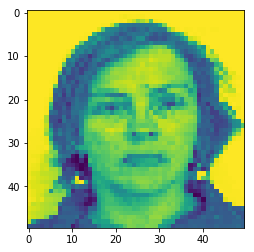

In [86]:
plt.imshow(cap)
plt.show()

In [88]:
img = np.zeros((1,50,50),dtype=np.uint8)

In [94]:
c = np.asmatrix(cap)

In [95]:
c

matrix([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [242, 235, 229, ...,  77,  92,  67],
        [232, 142,  88, ...,  83,  82,  79],
        [ 72,  66,  64, ...,  84,  90,  79]], dtype=uint8)

In [97]:
img[0,:,:] = c

In [100]:
x = np.asarray(img)

In [108]:
x[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [242, 235, 229, ...,  77,  92,  67],
       [232, 142,  88, ...,  83,  82,  79],
       [ 72,  66,  64, ...,  84,  90,  79]], dtype=uint8)

In [80]:
len(cap)

57

In [44]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [16]:
# img_name = []
# d = {}
# key = ''
# for root, dirs, files in os.walk('./aberdeen_resize_images'):
#     if not (root == './aberdeen_resize_images'):
#         key = root.split('\\')[1]
#         d[key] = []
#     for name in files:
#         img_name.append(name)
# #         d[key].append(name)
#         cap = cv2.imread('./aberdeen_resize_images/'+key+'/'+name)
# #         a = convert_gif_to_frames(cap)
# #         print(a[0][:])
#         d[key].append(cap)
# #         plt.imshow(a[0])
# #         plt.show()

In [17]:
# len(d['lisa'])

In [18]:
# hog = cv2.HOGDescriptor()
# descriptor = hog.compute(image)

In [19]:
# d['lisa'][1]

In [20]:
# len(descriptor)

In [21]:
# 1920*1200

In [22]:
# len(images)

In [23]:
# dfX = ddtrain['lisa']

In [24]:
# N = len(dfX.T)
# b = np.random.choice([0, 1], size=(N,), p=[1./3, 2./3])* 2 - 1;
# dfb = pd.DataFrame(b)

In [25]:
# lst = list(itertools.product([-1, 1], repeat=15))

In [26]:
# len(lst)

In [27]:
# dfXk.dot(dfbk)

In [28]:
# dfbk = dfb.copy()
# dfXk = dfX.copy()
# dfbk = dfbk.drop([1])
# dfXk = dfXk.drop([1],axis=1)

In [29]:
# dfXk.dot(dfbk)

In [30]:
# df1.T.dot(dfXk.dot(dfbk))[0][1]

In [31]:
# d.T.dot(dfXk.dot(dfbk))

In [32]:
#  df1 = pd.DataFrame(dfX.loc[:,1])

In [33]:
# df.dot(df1.T)

In [34]:
# df1

In [35]:
# df1 = df1.apply(lambda x: x*dfb.loc[1][0])

In [36]:
# df1.T

In [37]:
# df = pd.DataFrame()
# df[0] = [dfb.loc[1][0]]*2500

In [38]:
# df.dot(dfX.loc[:,1].T)

In [39]:
# k

In [40]:
# c = pd.DataFrame()
# c = tmp.T.dot(dfXk.dot(dfbk))

In [41]:
# list(c[list(c)[0]])[0]

In [42]:
# tmp = pd.DataFrame(dfX.loc[:,k])
# tmp = tmp.apply(lambda x: x*dfb.loc[k][0])
# delta = -4 * tmp.T.dot(dfXk.dot(dfbk))[0][1]

In [43]:
# delta

In [44]:
# images = np.array(images)

In [45]:
# images[0][0][0][0]

In [46]:
# len(d['lisa'][0][0])

In [48]:
# d.keys()

In [49]:
# random.randint(0,17)

In [58]:
# ddtrain = {}
# ddtest = {}
# for i in d:
#     t = []
#     while len(t) < 5:
#         x = random.randint(0,17)
#         if x in t:
#             continue
#         t.append(x)
#     print(i,t)
#     item = 0
#     ddtrain[i] = []
#     ddtest[i] = []
#     for j in d[i]:
#         X = []
#         for k in j:
#             for l in k:
#                 X.append(k[0][0])
#         if item in t:
#             ddtest[i].append(X[:])
#         else:
#             ddtrain[i].append(X[:])
#         item += 1

In [163]:
d['lisa']

[array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [254, 254, 254, ..., 255, 255, 255],
        [254, 254, 253, ..., 255, 255, 255],
        [254, 253, 252, ..., 255, 255, 255]], dtype=uint8),
 array([[249, 240, 244, ..., 239, 236, 238],
        [238, 237, 234, ..., 235, 232, 233],
        [237, 243, 241, ..., 237, 240, 233],
        ...,
        [188, 191, 189, ..., 183, 179, 185],
        [192, 199, 200, ..., 182, 186, 185],
        [195, 193, 197, ..., 182, 186, 184]], dtype=uint8),
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [254, 254, 253, ..., 254, 255, 255],
        [253, 253, 253, ..., 245, 238, 251],
        [254, 254, 255, ..., 255, 255, 255]], dtype=uint8),
 array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 25

In [72]:
def create_test_train_set(dataset,testSetSize):
    trainingSet = {}
    testingSet = {}
    for class_c in dataset:
        testSetIndex = []
        while len(testSetIndex) < testSetSize:
            test_image_i = random.randint(0,17)
            if test_image_i in testSetIndex:
                continue
            testSetIndex.append(test_image_i)
        if class_c=='michael' or class_c =='stephen':
            print('Class :',class_c,'\t','TestSet Index :',testSetIndex)
        else:
            print('Class :',class_c,'\t\t','TestSet Index :',testSetIndex)
        index_image_i = 0
        trainingSet[class_c] = []
        testingSet[class_c] = []
        for image_i in dataset[class_c]:
            image_vecotr = []
            for heightDimension in image_i:
                for widthDimension in heightDimension:
                    image_vecotr.append(widthDimension)
            if index_image_i in testSetIndex:
                testingSet[class_c].append(image_vecotr[:])
            else:
                trainingSet[class_c].append(image_vecotr[:])
            index_image_i += 1
    print()
    return trainingSet,testingSet

In [5]:
pd.DataFrame(ddtrain['lisa'])

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,249,240,244,247,250,244,248,250,253,250,...,205,202,183,181,185,183,180,182,186,184
1,255,255,255,255,255,255,255,255,255,255,...,37,239,255,255,255,235,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,251,234,199,227,244,226,237,253,252,253
3,242,243,245,241,243,240,240,243,240,242,...,184,182,183,154,142,137,111,155,174,180
4,243,239,234,236,234,237,234,240,238,235,...,131,203,213,187,212,142,129,122,172,195
5,255,255,255,255,255,255,255,255,255,255,...,197,194,131,139,219,253,254,254,254,254
6,255,255,255,255,255,255,255,255,255,255,...,254,255,255,255,255,255,255,255,255,255
7,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
8,255,255,255,255,255,255,255,255,255,255,...,254,254,254,254,254,255,255,255,255,255
9,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [52]:
# list(ddtrain)

In [53]:
# s=arrayOfArrayToMatlabString(ddtrain['lisa'])

In [54]:
# s

In [55]:
# def arrayOfArrayToMatlabString(array):
#     return '[' + ";".join(" ".join("%6g" % val for val in line) for line in array) + ']'

# HOG

In [7]:
ddtrain = {}
ddtest = {}
for i in d:
    t = []
    while len(t) < 5:
        x = random.randint(0,17)
        if x in t:
            continue
        t.append(x)
    print(i,t)
    item = 0
    ddtrain[i] = []
    ddtest[i] = []
    for j in d[i]:
        if item in t:
            ddtest[i].append(j)
        else:
            ddtrain[i].append(j)
        item += 1

lisa [16, 13, 11, 12, 3]
louise [16, 10, 13, 9, 1]
marie [1, 14, 6, 10, 17]
michael [16, 1, 0, 13, 3]
nick [6, 13, 4, 0, 14]
pat [11, 5, 16, 14, 9]
stephen [3, 10, 7, 8, 12]
trevor [3, 17, 14, 15, 9]


In [6]:
# image = cv2.imread("test1.png",0)
# winSize = (64,64)
# blockSize = (16,16)
# blockStride = (8,8)
# cellSize = (8,8)
# nbins = 9
# derivAperture = 1
# winSigma = 4.
# histogramNormType = 0
# L2HysThreshold = 2.0000000000000001e-01
# gammaCorrection = 0
# nlevels = 64
# hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
# #compute(img[, winStride[, padding[, locations]]]) -> descriptors
# winStride = (8,8)
# padding = (8,8)
# locations = ((10,20),)
# hist = hog.compute(image,winStride,padding,locations)
# item += 1

In [16]:
# x = pd.DataFrame(hist)

In [16]:
# x

In [7]:
# len(ddtrain)

8

In [8]:

for i in ddtrain:
    item = 0
    for j in ddtrain[i]:
        print(i,item)
#         image = cv2.imread("test1.png",0)
        winSize = (64,64)
        blockSize = (16,16)
        blockStride = (8,8)
        cellSize = (8,8)
        nbins = 9
        derivAperture = 1
        winSigma = 4.
        histogramNormType = 0
        L2HysThreshold = 2.0000000000000001e-01
        gammaCorrection = 0
        nlevels = 64
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                                histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
        #compute(img[, winStride[, padding[, locations]]]) -> descriptors
        winStride = (8,8)
        padding = (8,8)
        locations = ((10,20),)
        ddtrain[i][item] = hog.compute(ddtrain[i][item],winStride,padding,locations)
        item += 1

lisa 0
lisa 1
lisa 2
lisa 3
lisa 4
lisa 5
lisa 6
lisa 7
lisa 8
lisa 9
lisa 10
lisa 11
lisa 12
louise 0
louise 1
louise 2
louise 3
louise 4
louise 5
louise 6
louise 7
louise 8
louise 9
louise 10
louise 11
louise 12
marie 0
marie 1
marie 2
marie 3
marie 4
marie 5
marie 6
marie 7
marie 8
marie 9
marie 10
marie 11
marie 12
michael 0
michael 1
michael 2
michael 3
michael 4
michael 5
michael 6
michael 7
michael 8
michael 9
michael 10
michael 11
michael 12
nick 0
nick 1
nick 2
nick 3
nick 4
nick 5
nick 6
nick 7
nick 8
nick 9
nick 10
nick 11
nick 12
pat 0
pat 1
pat 2
pat 3
pat 4
pat 5
pat 6
pat 7
pat 8
pat 9
pat 10
pat 11
pat 12
stephen 0
stephen 1
stephen 2
stephen 3
stephen 4
stephen 5
stephen 6
stephen 7
stephen 8
stephen 9
stephen 10
stephen 11
stephen 12
trevor 0
trevor 1
trevor 2
trevor 3
trevor 4
trevor 5
trevor 6
trevor 7
trevor 8
trevor 9
trevor 10
trevor 11
trevor 12


In [9]:

for i in ddtest:
    item = 0
    for j in ddtest[i]:
        print(i,item)
#         image = cv2.imread("test1.png",0)
        winSize = (64,64)
        blockSize = (16,16)
        blockStride = (8,8)
        cellSize = (8,8)
        nbins = 9
        derivAperture = 1
        winSigma = 4.
        histogramNormType = 0
        L2HysThreshold = 2.0000000000000001e-01
        gammaCorrection = 0
        nlevels = 64
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                                histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
        #compute(img[, winStride[, padding[, locations]]]) -> descriptors
        winStride = (8,8)
        padding = (8,8)
        locations = ((10,20),)
        ddtest[i][item] = hog.compute(ddtest[i][item],winStride,padding,locations)
        item += 1

lisa 0
lisa 1
lisa 2
lisa 3
lisa 4
louise 0
louise 1
louise 2
louise 3
louise 4
marie 0
marie 1
marie 2
marie 3
marie 4
michael 0
michael 1
michael 2
michael 3
michael 4
nick 0
nick 1
nick 2
nick 3
nick 4
pat 0
pat 1
pat 2
pat 3
pat 4
stephen 0
stephen 1
stephen 2
stephen 3
stephen 4
trevor 0
trevor 1
trevor 2
trevor 3
trevor 4


In [10]:
for i in ddtrain:
    for j in range(0,len(ddtrain[i])):
        ddtrain[i][j] = sum(ddtrain[i][j].tolist(), [])

In [11]:
for i in ddtest:
    for j in range(0,len(ddtest[i])):
        ddtest[i][j] = sum(ddtest[i][j].tolist(), [])

In [15]:
# a = pd.DataFrame(dft[0][4])

In [53]:
for i in ddtrain:
    print(i,len(ddtrain[i]))

lisa 13
louise 13
marie 13
michael 13
nick 13
pat 13
stephen 13
trevor 13


In [171]:
x = pd.DataFrame(ddtrain['lisa'][0])

In [172]:
y = pd.DataFrame(ddtrain['lisa'][1])

In [176]:
pd.concat([x, y], axis=1, ignore_index=True)

,0,1
0,255,249
1,255,240
2,255,244
3,255,247
4,255,250
5,255,244
6,255,248
7,255,250
8,255,253
9,255,250


In [73]:
def mean_subtraction(trainingSet,trainSetSize):
    class_mean = pd.DataFrame()
    for class_c in trainingSet:
        print('Calculating mean for :',class_c)
        trainingSet[class_c] = pd.DataFrame(trainingSet[class_c])
        trainingSet[class_c] = trainingSet[class_c].T
        class_mean[class_c+'_'+'mean'] = trainingSet[class_c].sum(axis=1)/trainSetSize
    print()
    for class_c in trainingSet:
        print('Subtracting mean for :',class_c)
        for image_i in list(trainingSet[class_c]):
            trainingSet[class_c][image_i] = trainingSet[class_c][image_i] - class_mean[class_c+'_'+'mean']
    print()
    return trainingSet, class_mean

In [55]:
ddmean

,lisa_mean,louise_mean,marie_mean,michael_mean,nick_mean,pat_mean,stephen_mean,trevor_mean
0,251.846154,250.230769,250.153846,254.153846,248.461538,250.384615,251.384615,249.923077
1,252.000000,249.769231,249.307692,253.769231,247.538462,251.461538,251.000000,250.538462
2,251.153846,250.000000,250.076923,254.230769,247.615385,251.461538,250.923077,249.307692
3,251.461538,250.384615,250.000000,254.615385,247.615385,251.076923,251.153846,250.538462
4,251.384615,250.384615,250.846154,254.076923,247.384615,251.307692,251.615385,249.769231
5,251.692308,250.384615,249.923077,254.153846,247.615385,251.076923,251.153846,249.384615
6,251.461538,250.000000,250.000000,254.076923,247.384615,250.692308,251.076923,250.615385
7,251.846154,249.846154,250.615385,254.076923,247.538462,251.384615,252.230769,250.230769
8,252.076923,250.153846,250.846154,254.076923,247.076923,252.846154,251.692308,250.230769
9,251.692308,250.153846,249.846154,254.153846,248.000000,251.000000,252.692308,250.307692


In [214]:
ddd = pd.DataFrame()
for i in ddtrain:
    for j in ddtrain[i]:
        x = pd.DataFrame(j)
        ddd = pd.concat([x, ddd], axis=1, ignore_index=True)
#         ddmean[i+'_'+'mean'] = ddtrain[i].sum(axis=1)/N

In [215]:
N = len(list(ddd))

In [216]:
ddmean = pd.DataFrame()
ddmean['mean'] = ddd.sum(axis=1)/N

In [217]:
N

104

In [218]:
ddmean

,mean
0,250.548077
1,250.394231
2,250.326923
3,250.509615
4,250.605769
5,250.307692
6,250.673077
7,250.932692
8,250.913462
9,251.163462


In [56]:
for i in ddtrain:
    print('Subtracting mean for :',i)
    for j in list(ddtrain[i]):
        if j == 'mean':
            continue
        ddtrain[i][j] = ddtrain[i][j] - ddmean[i+'_'+'mean']

Subtracting mean for : lisa
Subtracting mean for : louise
Subtracting mean for : marie
Subtracting mean for : michael
Subtracting mean for : nick
Subtracting mean for : pat
Subtracting mean for : stephen
Subtracting mean for : trevor


In [57]:
for i in ddd:
    ddd[i] = ddd[i] - ddmean['mean']

NameError: name 'ddd' is not defined

In [74]:
def build_testing_set(testingSet):
    completeTestSet = pd.DataFrame()
    for class_c in testingSet:
        testingSet[class_c] = pd.DataFrame(testingSet[class_c])
        testingSet[class_c] = testingSet[class_c].T
    for class_c in testingSet:
        for image_i in list(testingSet[class_c]):
            completeTestSet[class_c+'_'+str(image_i)] = testingSet[class_c][image_i]
    print()
    return completeTestSet

In [60]:
dddtest

,lisa_0,lisa_1,lisa_2,lisa_3,lisa_4,louise_0,louise_1,louise_2,louise_3,louise_4,...,stephen_0,stephen_1,stephen_2,stephen_3,stephen_4,trevor_0,trevor_1,trevor_2,trevor_3,trevor_4
0,249,242,255,255,255,255,255,255,255,230,...,242,255,255,255,255,255,240,255,250,253
1,240,243,255,255,255,254,255,255,255,234,...,243,255,255,255,255,255,236,255,250,254
2,244,245,255,255,255,254,255,255,255,236,...,242,255,255,255,255,255,244,255,248,253
3,247,241,255,255,255,254,255,255,255,236,...,241,255,255,255,255,255,238,255,247,252
4,250,243,254,255,255,254,255,255,255,234,...,246,255,255,255,255,255,237,255,248,252
5,244,240,255,255,255,254,255,255,255,239,...,243,255,255,255,255,255,237,255,245,252
6,248,240,255,255,255,254,255,255,255,240,...,245,255,255,255,255,255,245,255,248,251
7,250,243,255,255,255,254,255,255,255,241,...,241,255,255,255,255,255,248,255,248,250
8,253,240,255,255,255,254,255,255,255,240,...,246,255,255,255,255,255,239,255,251,251
9,250,242,255,255,255,254,255,255,255,238,...,249,255,255,255,255,255,245,255,251,252


# L2 - PCA SVD

In [231]:
K = 6

In [230]:
dfrL2 = pd.DataFrame()
    
for i in ddtrain:
    print("Class :",i)
    U, sigma, V = np.linalg.svd(ddtrain[i])
    U = pd.DataFrame(U)
    sigma = pd.DataFrame(sigma)
    for k in range(0,K):
        print("Principal Component :",k)
        o = pd.DataFrame(U[k]*sigma[0][k])
        dfrL2[i+'_'+str(k)] = o[list(o)[0]].copy()


Class : lisa
Principal Component : 0
Principal Component : 1
Principal Component : 2
Principal Component : 3
Principal Component : 4
Principal Component : 5
Principal Component : 6
Principal Component : 7
Principal Component : 8
Principal Component : 9
Principal Component : 10
Principal Component : 11
Principal Component : 12
Principal Component : 13


KeyError: 13

In [196]:
sigma

,0
0,3.373995e+03
1,2.964139e+03
2,2.642486e+03
3,1.743107e+03
4,1.472203e+03
5,1.242768e+03
6,1.163041e+03
7,1.043089e+03
8,1.024575e+03
9,9.685669e+02


In [272]:
ddtrain['lisa'] = np.array(ddtrain['lisa']).T

In [197]:
U, sigma, V = np.linalg.svd(ddtrain['lisa'])
U = pd.DataFrame(U)
sigma = pd.DataFrame(sigma)
V = pd.DataFrame(V)

In [273]:
U, sigma, V = s_linalg.svd(ddtrain['lisa'])

In [274]:
U.shape

(2500, 2500)

In [275]:
U_matrix = np.matrix(U)
new_bases = U_matrix[:, 0:6]

In [276]:
pd.DataFrame(np.dot(new_bases.T, ddtrain['lisa']))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-1225.482347,1603.970145,-850.495567,-108.606648,1771.797219,1853.643323,-516.590690,-650.499647,-1304.072667,-1192.503121,-253.507108,-698.621003,1570.968110
1,-263.192822,-965.906253,2147.879420,1257.673218,669.158255,604.152321,-401.388303,-509.826841,-582.733253,-575.801227,-310.953060,-220.158933,-848.902524
2,234.539819,479.535049,285.759160,20.055547,114.204613,-459.738791,-1201.138237,-1402.719369,628.315038,595.305074,135.289653,199.355648,371.236795
3,-390.773791,292.966095,497.991573,-428.508775,284.851364,-108.124974,597.389852,18.289482,614.262878,662.590890,-1375.035690,-763.638155,97.739252
4,265.296393,-107.689366,545.126182,-1124.430426,205.122967,41.097914,33.810035,-19.737622,-166.214119,-283.233292,52.083443,447.108276,111.659615
5,-184.089651,497.409341,551.895240,72.664362,-547.154252,-473.396305,16.601863,219.607957,-303.170154,-194.488767,252.566492,-328.318591,419.872464


In [250]:
new_bases.shape

(2500, 6)

In [246]:
sigma.shape

(13,)

In [247]:
V.shape

(13, 13)

In [331]:
# a = pd.DataFrame(U[1]*sigma[0][1])

In [ ]:
# a

In [251]:
# df = pd.DataFrame(U[0]*sigma[0][0])

In [391]:
# dfrL2

In [206]:
error = sys.maxsize
min_error = sys.maxsize
test_label = ''
true_label = ''
labels = []
for principal_component_i in range(1,K+1):
    labels = []
    print('Principal_Component :',principal_component_i)
    for test_image_i in dddtest:
        true_label = test_image_i.split('_')[0]
        for class_c in ddtrain.keys():
            lst = []
            for i in range(1,principal_component_i+1):
                lst.append(str(i)+'_'+'trevor')
            #print(lst)
#             QQT = dfrL1[lst].dot(dfrL1[lst].T)
            df = pd.DataFrame()
            df[0] = dddtest[test_image_i].copy()
            error =  LA.norm((df[0] - ddmean['mean']) - dfrL1[lst].dot(dfrL1[lst].T.dot((df[0] - ddmean['mean']))))
            if error < min_error:
                min_error = error
                test_label = class_c
        #print('Test Image :',test_image_i,'True Label :',true_label,'Test Label',test_label)
        l = []
        l.append(true_label)
        l.append(test_label)
        labels.append(l)
    accurate = 0
    for i in labels:
        if i[0] == i[1]:
            accurate += 1
    #print(accurate)
    print('Accuracy :',round(((accurate/len(list(dddtest)))*100),2),'\t','Error :',round((((len(list(dddtest))-accurate)/len(list(dddtest)))*100),2))

Principal_Component : 1
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 2
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 3
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 4
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 5
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 6
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 7
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 8
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 9
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 10
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 11
Accuracy : 12.5 	 Error : 87.5
Principal_Component : 12
Accuracy : 12.5 	 Error : 87.5


In [55]:
#dddtest

In [56]:
#dddtest[['lisa_0']]

In [57]:
# df = pd.DataFrame.from_dict(dd, orient='index')

In [58]:
# item = 0
# X = []
# for i in images:
#     tmp = []
#     for j in i:
#         for k in j:
#             tmp.append(k[0])
#     X.append(tmp)
#     item += 1

In [59]:
# len(X[90])

In [60]:
# len(images[0][0])

In [61]:
# m = 99999999999999
# for i in X:
#     m = min(len(i),m)

In [62]:
# m

In [63]:
# for i in range(0,len(X)):
#     X[i] = X[i][0:m]

In [64]:
# X = np.array(X)

In [65]:
# random.randrange(-1, 1, 2)

In [66]:
# len(X.T)

In [67]:
# b = [-1]*100

In [68]:
# dfX = pd.DataFrame(X)

In [69]:
# dfX

In [70]:
# dfb = pd.DataFrame(b)

In [71]:
#dfX.T.dot(dfb)/LA.norm(dfX.T.dot(dfb))

In [72]:
# (dfX.T.loc[:,0]*int(dfb.iloc[0])).dot(dfX.T.dot(dfb))

In [73]:
# df = pd.DataFrame([[0, 1, -2, -1], [1, 1, 1, 1]])
# other = pd.DataFrame([[0, 1], [1, 2], [-1, -1], [2, 0]])
# df.dot(other)

In [74]:
# df = pd.DataFrame

In [75]:
# df.iloc[0] = 0

In [76]:
# other

In [77]:
# dfX = pd.DataFrame(ddtrain['lisa'])

In [78]:
# len(dfX.T)

In [79]:
# Qprop,Bprop,l_best = l1pca_SBF_rank1_simplified(dfX.T,10)

In [80]:
# Qprop

# L1 PCA Single Bit Flip

In [80]:
def l1pca_SBF_rank1_simplified(dfX,L):
    N = len(dfX.T) #Number of data points
    max_iter = 1000 #Number of iteration    
    delta = [0] * N #array to store quadratic value
    obj_val = 0 #initialize the objective function's value ||X*b||_2^2
    
    for i in range(0,L): #loop through initializations
#         b = []
#         for j in range(0,N): #random initalization of the b vector
#             temp = 0
#             while temp == 0:
#                 temp = random.randint(-1,1)
#             b.append(temp)
#         b = np.array(b)
        b = np.random.choice([0, 1], size=(N,), p=[1./3, 2./3])* 2 - 1;
        dfb = pd.DataFrame(b)
#         print('Initializtion : ',i)
        j = 0
        for j in range(0,max_iter): #loop of iterations for bit flipping
            for k in range(0,N): #loop over N bits in b
#                 print('Initialization: ',i,'Iteration: ',j,'Sample: ',k)
                dfbk = dfb.copy()
                dfXk = dfX.copy()
                dfbk = dfbk.drop([k])
                dfXk = dfXk.drop([k],axis=1)
#                 bk = np.delete(b,k,0) #remove the i-th bit
#                 Xk = np.delete(X,k,1) #remove the i-th data sample
                tmp = pd.DataFrame(dfX.loc[:,k])
                tmp = tmp.apply(lambda x: x*dfb.loc[k][0])
                tmp = tmp.T.dot(dfXk.dot(dfbk))
                delta[k] = -4 * list(tmp[list(tmp)[0]])[0] #calculate the "increase of the objective function" after flipping the i-th bit 
            ID = sorted(range(len(delta)), key=lambda g: delta[g],reverse = True) #sort delta and find the bit that leads to the highest increase
            #delta.sort(reverse = True)
            val = np.sort(delta)[::-1]
            
            if val[0] > 0: #if the highest "increase" is positive
                b[ID[0]] = -b[ID[0]] #then flip the corresponding bit in b
            else:
#                 print(j)
                break #otherwise, SBF terminates
        tmp = LA.norm(dfX.dot(dfb)) #calculate the  objective function's value
        if tmp > obj_val: #if larger than the old obj function value
            obj_val = tmp
            bopt = b #then update the obj function value, and the optimal b
            l_best = i
    dfbopt = pd.DataFrame(bopt)
    Qprop = dfX.dot(dfbopt)/LA.norm(dfX.dot(dfbopt)) #PCA X*bopt/norm(X*bopt)
    Bprop = dfbopt
    return Qprop,Bprop,l_best,j

In [197]:
# x = [[1,2],[2,3],[3,4]]
# df = pd.DataFrame(x)
# Qprop,Bprop,l_best,iteration = l1pca_SBF_rank1_simplified(df,10)

In [454]:
# Qprop

In [455]:
# l_best

# Greedy Algorithm

In [62]:
K = 6

In [14]:

dfrL1 = pd.DataFrame()
for k in range(1,K+1):
    print('Principal Component: ',k)
    Qprop,Bprop,l_best,iteration = l1pca_SBF_rank1_simplified(ddd,5)
    print('Best Initialization :',l_best,'\t\t','Iteration :',iteration)
    dfrL1[str(k)] = Qprop[0].values
    ddd = ddd - dfrL1[[str(k)].dot(dfrL1[[str(k)]].T.dot(ddd))

SyntaxError: unexpected EOF while parsing (<ipython-input-14-59f149c5fd1c>, line 7)

In [76]:
def greedy_algorithm_find_k_principal_component(trainingSet,number_of_principal_component,number_of_initialization):
    QrL1 = pd.DataFrame()
    for principal_component_i in range(1,number_of_principal_component+1):
        print('Principal Component: ',principal_component_i)
        for class_c in trainingSet:
            Qprop,Bprop,l_best,iteration = l1pca_SBF_rank1_simplified(trainingSet[class_c],number_of_initialization)
            if class_c=='michael' or class_c =='stephen':
                print('Class :',class_c,'\t','Best Initialization :',l_best,'\t\t','Iteration :',iteration)
            else:
                print('Class :',class_c,'\t\t','Best Initialization :',l_best,'\t\t','Iteration :',iteration)
            QrL1[str(principal_component_i)+'_'+str(class_c)] = Qprop[0].values
        for class_c in trainingSet:
            trainingSet[class_c] = trainingSet[class_c] - QrL1[[str(principal_component_i)+'_'+str(class_c)]].dot(QrL1[[str(principal_component_i)+'_'+str(class_c)]].T.dot(trainingSet[class_c]))
    print()
    return QrL1

In [66]:
dfrL1

,1_lisa,1_louise,1_marie,1_michael,1_nick,1_pat,1_stephen,1_trevor,2_lisa,2_louise,...,5_stephen,5_trevor,6_lisa,6_louise,6_marie,6_michael,6_nick,6_pat,6_stephen,6_trevor
0,-0.004788,-0.004377,-0.004441,-0.000904,0.000783,0.004724,-0.003892,0.003957,0.001916,-0.003234,...,-0.005835,0.003623,0.002475,0.000107,-0.000485,-0.002723,0.002856,-0.001543,0.001700,0.000651
1,-0.004555,-0.004710,-0.005004,-0.001315,0.000829,0.003622,-0.004305,0.003255,0.000839,-0.003585,...,-0.005010,0.003714,0.000242,-0.001315,0.001642,-0.003960,0.003944,-0.000344,0.001307,0.002628
2,-0.005840,-0.004618,-0.004231,-0.000822,0.000574,0.003622,-0.004388,0.004359,0.000972,-0.003379,...,-0.003560,0.004144,0.000090,-0.000198,-0.000312,-0.002475,0.004127,-0.000227,0.000712,0.003565
3,-0.005372,-0.004068,-0.004165,-0.000411,0.000977,0.004016,-0.004140,0.002956,0.000962,-0.003199,...,-0.005519,0.004247,0.000227,-0.000158,-0.000196,-0.001238,0.002483,-0.000473,-0.000168,0.002489
4,-0.005489,-0.004217,-0.003314,-0.000987,0.000636,0.003780,-0.003643,0.003347,0.000643,-0.003138,...,-0.004246,0.002626,-0.000494,-0.000139,-0.000568,-0.002970,0.004662,-0.000090,0.001219,0.002875
5,-0.005022,-0.004217,-0.004529,-0.000904,0.000977,0.004016,-0.004140,0.003543,0.000848,-0.003138,...,-0.003074,0.004659,0.000093,-0.000298,-0.003394,-0.002723,0.001321,-0.001884,0.000299,0.005120
6,-0.005372,-0.004618,-0.004596,-0.000987,0.001341,0.004410,-0.004223,0.002588,0.000533,-0.003379,...,-0.002444,0.001595,-0.000682,-0.000133,-0.000917,-0.002970,0.002327,-0.002050,0.001454,0.000583
7,-0.004788,-0.004778,-0.003977,-0.000987,0.001132,0.003701,-0.002981,0.002485,0.001273,-0.003475,...,-0.002257,0.003729,0.001102,-0.001123,-0.001591,-0.002970,0.001915,-0.001610,0.000077,0.003527
8,-0.004438,-0.004457,-0.003601,-0.000987,0.001860,0.002205,-0.003560,0.002485,0.000515,-0.003282,...,-0.000987,0.003436,-0.000411,-0.000597,-0.001160,-0.002970,0.002181,-0.001300,-0.000943,0.000652
9,-0.005022,-0.004457,-0.004607,-0.000904,0.001612,0.004095,-0.002484,0.002864,0.000419,-0.003282,...,-0.000961,0.002780,-0.000816,-0.000939,-0.003584,-0.002723,0.000649,-0.001157,0.000955,0.002512


In [84]:
#ddtrain['lisa']

In [85]:
#ddtrain['lisa'] - dfrL1[['1_lisa']].dot(dfrL1[['1_lisa']].T.dot(ddtrain['lisa']))

In [86]:
#a = ['1_lisa','2_lisa']

In [87]:
#dfrL1[a].dot(dfrL1[a].T)

In [109]:
# dfrL1

In [89]:
# ddtrain.keys()

In [90]:
# list(ddmean)

In [91]:
# df = dddtest['lisa_0'].copy

In [92]:
# df = pd.DataFrame()
# df[0] = dddtest['lisa_0'].copy()

In [93]:
# -sys.maxsize

In [94]:
# len(list(dddtest))

In [95]:
# tmp_dddtest = dddtest[['lisa_0']]

In [67]:
K

6

# Nearest Neighbor

In [20]:
t = dddtest.copy()

In [32]:
list(t)

['lisa_0',
 'lisa_1',
 'lisa_2',
 'lisa_3',
 'lisa_4',
 'louise_0',
 'louise_1',
 'louise_2',
 'louise_3',
 'louise_4',
 'marie_0',
 'marie_1',
 'marie_2',
 'marie_3',
 'marie_4',
 'michael_0',
 'michael_1',
 'michael_2',
 'michael_3',
 'michael_4',
 'nick_0',
 'nick_1',
 'nick_2',
 'nick_3',
 'nick_4',
 'pat_0',
 'pat_1',
 'pat_2',
 'pat_3',
 'pat_4',
 'stephen_0',
 'stephen_1',
 'stephen_2',
 'stephen_3',
 'stephen_4',
 'trevor_0',
 'trevor_1',
 'trevor_2',
 'trevor_3',
 'trevor_4']

In [49]:
dddtest = t.copy()

In [50]:
dddtest

,lisa_0,lisa_1,lisa_2,lisa_3,lisa_4,louise_0,louise_1,louise_2,louise_3,louise_4,...,stephen_0,stephen_1,stephen_2,stephen_3,stephen_4,trevor_0,trevor_1,trevor_2,trevor_3,trevor_4
0,255,255,255,255,240,244,242,255,255,231,...,255,249,255,255,255,255,255,255,235,236
1,255,255,255,255,242,243,242,255,255,232,...,255,247,255,255,255,255,255,255,237,245
2,255,255,255,255,240,243,240,255,255,233,...,255,244,255,255,255,255,255,255,233,239
3,255,255,255,255,240,245,240,255,255,236,...,255,251,255,255,255,255,255,255,239,244
4,255,254,255,255,242,243,238,255,255,240,...,255,251,255,255,255,255,255,255,238,246
5,255,255,255,255,238,244,242,255,255,234,...,255,251,255,255,255,255,255,255,231,244
6,255,255,255,255,245,240,239,255,255,238,...,255,244,255,255,255,255,255,255,245,248
7,255,255,255,255,244,241,238,255,255,239,...,255,249,255,255,255,255,255,255,238,247
8,255,255,255,255,244,241,242,255,255,236,...,255,245,255,255,255,255,255,255,243,243
9,255,255,255,255,243,239,244,255,255,237,...,255,249,255,255,255,255,255,255,240,243


In [41]:
# ''error = sys.maxsize
# min_error = sys.maxsize
# test_label = ''
# true_label = ''
# labels = []
# for principal_component_i in range(1,K+1):
#     labels = []
#     print('Principal_Component :',principal_component_i)
#     for test_image_i in dddtest:
#         true_label = test_image_i.split('_')[0]
#         for class_c in ddtrain.keys():
#             lst = []
#             for i in range(1,principal_component_i+1):
#                 lst.append(str(i)+'_'+'trevor')
#             #print(lst)
# #             QQT = dfrL1[lst].dot(dfrL1[lst].T)
#             df = pd.DataFrame()
#             df[0] = dddtest[test_image_i].copy()
#             error =  LA.norm((df[0] - ddmean['mean']) - dfrL1[lst].dot(dfrL1[lst].T.dot((df[0] - ddmean['mean']))))
#             if error < min_error:
#                 min_error = error
#                 test_label = class_c
#         #print('Test Image :',test_image_i,'True Label :',true_label,'Test Label',test_label)
#         l = []
#         l.append(true_label)
#         l.append(test_label)
#         labels.append(l)
#     accurate = 0
#     for i in labels:
#         if i[0] == i[1]:
#             accurate += 1
#     #print(accurate)
#     print('Accuracy :',round(((accurate/len(list(dddtest)))*100),2),'\t','Error :',round((((len(list(dddtest))-accurate)/len(list(dddtest)))*100),2))''

In [81]:
def NearestNeighbor(testSet,class_mean,QrL1,number_of_principal_component,classes):
    for principal_component_i in range(1,number_of_principal_component+1):
        labels = []
        print('Principal_Component :',principal_component_i)
        for test_image_i in testSet:
            error = sys.maxsize
            min_error = sys.maxsize
            test_label = ''
            true_label = test_image_i.split('_')[0]
            for class_c in classes:
                number_of_components = []
                for component_i in range(1,principal_component_i+1):
                    number_of_components.append(str(component_i)+'_'+class_c)
                image_i = pd.DataFrame()
                image_i[0] = testSet[test_image_i].copy()
                error =  LA.norm((image_i[0] - class_mean[class_c+'_'+'mean']) - QrL1[number_of_components].dot(QrL1[number_of_components].T.dot((image_i[0] - class_mean[class_c+'_'+'mean']))))
                if error < min_error:
                    min_error = error
                    test_label = class_c
            image_label = []
            image_label.append(true_label)
            image_label.append(test_label)
            labels.append(image_label)
        accurate = 0
        for label in labels:
            if label[0] == label[1]:
                accurate += 1
        print('Accuracy :',round(((accurate/len(list(testSet)))*100),2),'\t','Error :',round((((len(list(testSet))-accurate)/len(list(testSet)))*100),2))
        print()

In [79]:
def face_recognition_l1_pca(dataset_name,num_of_principal_component,num_of_initailization):
    if dataset_name == 'Aberdeen':
        dataset = read_aberdeen_dataset()
    number_of_class = len(dataset)
    number_of_images_per_class = len(dataset[list(dataset)[0]])
    print('Number of Classes :',number_of_class,'\t','Number of Images per Class :',number_of_images_per_class)
    print()
    number_of_train_images_per_class = math.ceil(number_of_images_per_class * 0.8)
    number_of_test_images_per_class = math.floor(number_of_images_per_class * 0.2)
    print('Number of train images per class :',number_of_train_images_per_class,'\t','Number of test images per class :',number_of_test_images_per_class)
    print()
    trainingSet,testingSet = create_test_train_set(dataset,number_of_test_images_per_class)
    trainingSet,class_mean = mean_subtraction(trainingSet,number_of_train_images_per_class)
    classes = list(trainingSet)
    testingSet = build_testing_set(testingSet)
    number_of_principal_component = num_of_principal_component
    number_of_initailization = num_of_initailization
    QrL1 = greedy_algorithm_find_k_principal_component(trainingSet,number_of_principal_component,number_of_initailization)
    NearestNeighbor(testingSet,class_mean,QrL1,number_of_principal_component,classes)

In [82]:
number_of_experiments = 2
num_of_principal_component = 1
num_of_initailization = 10
dataset_name = 'Aberdeen' 
for expirement in range(number_of_experiments):
    face_recognition_l1_pca(dataset_name,num_of_principal_component,num_of_initailization)


Number of Classes : 8 	 Number of Images per Class : 18

Number of train images per class : 15 	 Number of test images per class : 3

Class : lisa 		 TestSet Index : [9, 4, 13]
Class : louise 		 TestSet Index : [7, 10, 13]
Class : marie 		 TestSet Index : [8, 7, 2]
Class : michael 	 TestSet Index : [7, 15, 16]
Class : nick 		 TestSet Index : [2, 7, 9]
Class : pat 		 TestSet Index : [17, 3, 9]
Class : stephen 	 TestSet Index : [7, 9, 5]
Class : trevor 		 TestSet Index : [10, 13, 1]

Calculating mean for : lisa
Calculating mean for : louise
Calculating mean for : marie
Calculating mean for : michael
Calculating mean for : nick
Calculating mean for : pat
Calculating mean for : stephen
Calculating mean for : trevor

Subtracting mean for : lisa
Subtracting mean for : louise
Subtracting mean for : marie
Subtracting mean for : michael
Subtracting mean for : nick
Subtracting mean for : pat
Subtracting mean for : stephen
Subtracting mean for : trevor


Principal Component:  1
Class : lisa 		 B

In [97]:
# accurate = 0
# for i in labels:
#     if i[0] == i[1]:
#         accurate += 1
# accurate

In [98]:
# len(labels)

In [110]:
# a = [[2,3,4],[5,6,7]]

In [112]:
# df = pd.DataFrame(a)

In [118]:
# df*2

In [99]:
# df[0]

In [100]:
# LA.norm((df[0] - ddmean['lisa'+'_'+'mean'])-QQT.dot((df[0] - ddmean['lisa'+'_'+'mean'])))

In [101]:
# LA.norm((df[0] - ddmean['lisa'+'_'+'mean']) - QQT.dot((df[0] - ddmean['lisa'+'_'+'mean'])))

# Exaustive Search

In [126]:
K = 6

In [127]:
dfbopt = pd.DataFrame()
dfrL1 = pd.DataFrame()
b = list(itertools.product([-1, 1], repeat=N))
for principal_component_i in range(1,K+1):
    print('Principal Component :',principal_component_i)
    for class_c in ddtrain:
        max_v = -sys.maxsize
        v = -sys.maxsize
        print('Class :',class_c)
        for i in b:
            dfb = pd.DataFrame(list(i))
            v = LA.norm(ddtrain[class_c].dot(dfb))
            if v > max_v:
                max_v = v
                dfbopt[class_c+'_'+str(principal_component_i)] = dfb[list(dfb)[0]].copy()
    for class_c in ddtrain:
        dfrL1[class_c+'_'+str(principal_component_i)] = ddtrain[class_c].dot(dfbopt[class_c+'_'+str(principal_component_i)])/LA.norm(ddtrain[class_c].dot(dfbopt[class_c+'_'+str(principal_component_i)]))
        ddtrain[class_c] = ddtrain[class_c] - dfrL1[[class_c+'_'+str(principal_component_i)]].dot(dfrL1[[class_c+'_'+str(principal_component_i)]].T.dot(ddtrain[class_c]))

Principal Component : 1
Class : lisa
Class : louise
Principal Component : 2
Class : lisa
Class : louise
Principal Component : 3
Class : lisa
Class : louise
Principal Component : 4
Class : lisa
Class : louise
Principal Component : 5
Class : lisa
Class : louise
Principal Component : 6
Class : lisa
Class : louise


In [104]:
# dfbopt

In [105]:
# max_v

In [128]:
dfrL1 = pd.DataFrame()
for i in dfbopt:
    dfrL1[i] = ddtrain[i.split('_')[0]].dot(dfbopt[i])/LA.norm(ddtrain[i.split('_')[0]].dot(dfbopt[i]))
    #dfrL1[i] = dfrL1.div(LA.norm(ddtrain[i.split('_')[0]].dot(dfbopt[i])))
    ddtrain[i.split('_')[0]] = ddtrain[i.split('_')[0]] - dfrL1[[i]].dot(dfrL1[[i]].T.dot(ddtrain[i.split('_')[0]]))

In [107]:
# dfrL1

# Nearest Neighbor

In [129]:
error = sys.maxsize
min_error = sys.maxsize
test_label = ''
true_label = ''
labels = []
for principal_component_i in range(1,K+1):
    labels = []
    print('Principal_Component :',principal_component_i)
    for test_image_i in dddtest:
        true_label = test_image_i.split('_')[0]
        for class_c in ddtrain.keys():
            lst = []
            for i in range(1,principal_component_i+1):
                lst.append(class_c+'_'+str(i))
            #print(lst)
            QQT = dfrL1[lst].dot(dfrL1[lst].T)
            df = pd.DataFrame()
            df[0] = dddtest[test_image_i].copy()
            error =  LA.norm((df[0] - ddmean[class_c+'_'+'mean']) - QQT.dot((df[0] - ddmean[class_c+'_'+'mean'])))
            if error < min_error:
                min_error = error
                test_label = class_c
        #print('Test Image :',test_image_i,'True Label :',true_label,'Test Label',test_label)
        l = []
        l.append(true_label)
        l.append(test_label)
        labels.append(l)
    accurate = 0
    for i in labels:
        if i[0] == i[1]:
            accurate += 1
    #print(accurate)
    print('Accuracy :',round(((accurate/len(list(dddtest)))*100),2),'\t','Error :',round((((len(list(dddtest))-accurate)/len(list(dddtest)))*100),2))

Principal_Component : 1
Accuracy : 50.0 	 Error : 50.0
Principal_Component : 2
Accuracy : 50.0 	 Error : 50.0
Principal_Component : 3
Accuracy : 50.0 	 Error : 50.0
Principal_Component : 4
Accuracy : 50.0 	 Error : 50.0
Principal_Component : 5
Accuracy : 50.0 	 Error : 50.0
Principal_Component : 6
Accuracy : 50.0 	 Error : 50.0


In [145]:

class dataset_class:

    def __init__(self, required_no):

        #Dataset Name
        self.dir = ("aberdeen_resize_images")

        self.images_name_for_train = []
        self.target_name_as_array= []
        self.target_name_as_set = {}
        self.y_for_train = []
        self.no_of_elements_for_train = []

        self.images_name_for_test = []
        self.y_for_test = []
        self.no_of_elements_for_test = []


        per_no = 0
        for name in os.listdir(self.dir):
            dir_path = os.path.join(self.dir, name)
            if os.path.isdir(dir_path):
                if len(os.listdir(dir_path)) >= required_no:
                    i = 0
                    for img_name in os.listdir(dir_path):
                        img_path = os.path.join(dir_path, img_name)


                        if i < required_no:
                            self.images_name_for_train += [img_path]
                            self.y_for_train += [per_no]
                            if len(self.no_of_elements_for_train) > per_no:
                                self.no_of_elements_for_train[per_no] += 1
                            else:
                                self.no_of_elements_for_train += [1]

                            if i is 0:
                                self.target_name_as_array += [name]
                                self.target_name_as_set[per_no] = name

                        else:
                            self.images_name_for_test += [img_path]
                            self.y_for_test += [per_no]
                            if len(self.no_of_elements_for_test) > per_no:
                                self.no_of_elements_for_test[per_no] += 1
                            else:
                                self.no_of_elements_for_test += [1]



                        i += 1
                    per_no += 1




In [146]:
no_of_images_of_one_person = 13
dataset_obj = dataset_class(no_of_images_of_one_person)


#Data For Training
images_names = dataset_obj.images_name_for_train
y = dataset_obj.y_for_train
no_of_elements = dataset_obj.no_of_elements_for_train
target_names = dataset_obj.target_name_as_array

#Data For Testing
images_names_for_test = dataset_obj.images_name_for_test
y_for_test = dataset_obj.y_for_test
no_of_elements_for_test = dataset_obj.no_of_elements_for_test


img_width, img_height = 50, 50

In [147]:
len(y)

104

In [148]:

class images_to_matrix_class:


    def __init__(self, images_name, img_width, img_height):

        self.images_name = images_name
        self.img_width = img_width
        self.img_height = img_height
        self.img_size = (img_width * img_height)



    def get_matrix(self):

        col = len(self.images_name)
        img_mat = np.zeros((self.img_size, col))

        i = 0
        for name in self.images_name:
            gray = cv2.imread(name, 0)
            gray = cv2.resize(gray, (self.img_height, self.img_width))
            mat = np.asmatrix(gray)
            img_mat[:, i] = mat.ravel()
            i += 1
        return img_mat


In [172]:

class pca_class:


    def give_p(self, d):
        sum = np.sum(d)
        sum_85 = self.quality_percent * sum/100
        temp = 0
        p = 0
        while temp < sum_85:
            temp += d[p]
            p += 1
        return p

    def reduce_dim(self):

        p, d, q = s_linalg.svd(self.images, full_matrices=True)
        p_matrix = np.matrix(p)
        d_diag = np.diag(d)
        q_matrix = np.matrix(q)
        p = self.give_p(d)
        print('Principal Components :',p)
        self.new_bases = p_matrix[:, 0:p]
        self.new_coordinates = np.dot(self.new_bases.T, self.images)
        return self.new_coordinates.T


    def __init__(self, images, y, target_names, no_of_elements, quality_percent):
        self.no_of_elements = no_of_elements
        self.images = np.asarray(images)
        self.y = y
        self.target_names = target_names
        mean = np.mean(self.images, 1)
        self.mean_face = np.asmatrix(mean).T
        self.images = self.images - self.mean_face
        self.quality_percent = quality_percent

    def original_data(self, new_coordinates):
        return self.mean_face + (np.dot(self.new_bases, new_coordinates.T))


    def show_eigen_face(self, height, width, min_pix_int, max_pix_int, eig_no):
        ev = self.new_bases[:, eig_no:eig_no + 1]
        min_orig = np.min(ev)
        max_orig = np.max(ev)
        ev = min_pix_int + (((max_pix_int - min_pix_int)/(max_orig - min_orig)) * ev)
        ev_re = np.reshape(ev, (height, width))
        cv2.imshow("Eigen Face " + str(eig_no),  cv2.resize(np.array(ev_re, dtype = np.uint8),(200, 200)))
        cv2.waitKey()

    def new_cord(self, name, img_height, img_width):
        img = cv2.imread(name)
        gray = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (img_height, img_width))
        img_vec = np.asmatrix(gray).ravel()
#         print('yosh',img_vec.shape)
        img_vec = img_vec.T
        new_mean = ((self.mean_face * len(self.y)) + img_vec)/(len(self.y) + 1)
        img_vec = img_vec - new_mean
        return np.dot(self.new_bases.T, img_vec)

    def new_cord_for_image(self, image):
        img_vec = np.asmatrix(image).ravel()
        
        img_vec = img_vec.T
        new_mean = ((self.mean_face * len(self.y)) + img_vec) / (len(self.y) + 1)
        img_vec = img_vec - new_mean
        return np.dot(self.new_bases.T, img_vec)

    def recognize_face(self, new_cord_pca, k=0):
        classes = len(self.no_of_elements)
        start = 0
        distances = []
        for i in range(classes):
            temp_imgs = self.new_coordinates[:, int(start): int(start + self.no_of_elements[i])]
            mean_temp = np.mean(temp_imgs, 1)
#             print(mean_temp.shape,i,self.no_of_elements[i])
            start = start + self.no_of_elements[i]
            dist = np.linalg.norm(new_cord_pca - mean_temp)
            distances += [dist]
        min = np.argmin(distances)

        #Temp Threshold
        threshold = 100000
        if distances[min] < threshold:
            print("Person", k, ":", min, self.target_names[min])
            return self.target_names[min]
        else:
            print("Person", k, ":", min, 'Unknown')
            return 'Unknown'



In [173]:
i_t_m_c = images_to_matrix_class(images_names, img_width, img_height)

In [174]:
scaled_face = i_t_m_c.get_matrix()

In [175]:
my_algo = pca_class(scaled_face, y, target_names, no_of_elements, 90)

In [176]:
new_coordinates = my_algo.reduce_dim()

Principal Components : 79


In [177]:
start = 0
temp_imgs = new_coordinates[:, int(start): int(start + 8)]

In [178]:
mean_temp = np.mean(temp_imgs, 1)

In [179]:
# pd.DataFrame(new_coordinates)

In [180]:
correct = 0
wrong = 0
i = 0
# net_time_of_reco = 0

for img_path in images_names_for_test:

#     time_start = time.process_time()
    find_name = my_algo.recognize_face(my_algo.new_cord(img_path, img_height, img_width))
#     time_elapsed = (time.process_time() - time_start)
#     net_time_of_reco += time_elapsed
    rec_y = y_for_test[i]
    rec_name = target_names[rec_y]
    if find_name is rec_name:
        correct += 1
        print("Correct", " Name:", find_name)
    else:
        wrong +=1
        print("Wrong:", " Real Name:", rec_name, "Rec Y:", rec_y, "Find Name:", find_name)
    i+=1

print("Correct", correct)
print("Wrong", wrong)
print("Total Test Images", i)
print("Percent", correct/i*100)
print("Total Person", len(target_names))
print("Total Train Images", no_of_images_of_one_person * len(target_names))
# print("Total Time Taken for reco:", time_elapsed)
# print("Time Taken for one reco:", time_elapsed/i)
# print("Training Time", training_time)

Person 0 : 0 lisa
Correct  Name: lisa
Person 0 : 0 lisa
Correct  Name: lisa
Person 0 : 0 lisa
Correct  Name: lisa
Person 0 : 0 lisa
Correct  Name: lisa
Person 0 : 0 lisa
Correct  Name: lisa
Person 0 : 1 louise
Correct  Name: louise
Person 0 : 1 louise
Correct  Name: louise
Person 0 : 1 louise
Correct  Name: louise
Person 0 : 1 louise
Correct  Name: louise
Person 0 : 1 louise
Correct  Name: louise
Person 0 : 2 marie
Correct  Name: marie
Person 0 : 2 marie
Correct  Name: marie
Person 0 : 2 marie
Correct  Name: marie
Person 0 : 2 marie
Correct  Name: marie
Person 0 : 2 marie
Correct  Name: marie
Person 0 : 3 michael
Correct  Name: michael
Person 0 : 3 michael
Correct  Name: michael
Person 0 : 3 michael
Correct  Name: michael
Person 0 : 3 michael
Correct  Name: michael
Person 0 : 3 michael
Correct  Name: michael
Person 0 : 4 nick
Correct  Name: nick
Person 0 : 4 nick
Correct  Name: nick
Person 0 : 4 nick
Correct  Name: nick
Person 0 : 4 nick
Correct  Name: nick
Person 0 : 4 nick
Correct  N